In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install sk-video

     |████████████████████████████████| 2.3 MB 3.5 MB/s 


In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
!wget -O 'data.csv' 'https://drive.google.com/uc?id=1pCx7XFmjFtD4RfmfKpeZgx8ijaXmZDld&confirm=t'
!wget -O 'input_data_random_800.npy' 'https://drive.google.com/uc?id=10uilSyuHEbl6f6zJgh89_-uRfev8rQ8N&confirm=t'
!wget -O 'videoIDs_random_800.npy' 'https://drive.google.com/uc?id=1-0ZOCy3t7sO5bowBc4AcmOfLacqcRlEI&confirm=t'
!wget -O 'c3d.py' 'https://drive.google.com/uc?id=1RC9trsgIo2OsM8dV7CPg73drqSRZMr8j&confirm=t'
!wget -O 'sports1M_utils.py' 'https://drive.google.com/uc?id=1S49OSW2pCUPPD9F-763mG-aBx2gBOr2i&confirm=t'

#Generated once from this notebook
!wget -O features.zip 'https://drive.google.com/uc?id=1r8fPo9rtOC6Uk2Kz7xvlqULgW3z5PfSU&confirm=t'
!unzip features.zip
!wget -O motion_features.zip 'https://drive.google.com/uc?id=1-3Vcr9Cn9qFFHFoNMhdbsi13dTPiB3a_&confirm=t'
!unzip motion_features.zip

--2022-03-13 18:27:38--  https://drive.google.com/uc?id=1pCx7XFmjFtD4RfmfKpeZgx8ijaXmZDld&confirm=t
Resolving drive.google.com (drive.google.com)... 142.250.157.139, 142.250.157.138, 142.250.157.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.157.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9u214tk2k9urlaksndc7tbvocsc3nvqm/1647196050000/04941579238877149480/*/1pCx7XFmjFtD4RfmfKpeZgx8ijaXmZDld [following]
--2022-03-13 18:27:39--  https://doc-0s-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9u214tk2k9urlaksndc7tbvocsc3nvqm/1647196050000/04941579238877149480/*/1pCx7XFmjFtD4RfmfKpeZgx8ijaXmZDld
Resolving doc-0s-0c-docs.googleusercontent.com (doc-0s-0c-docs.googleusercontent.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to doc-0s-0c-docs.googleusercontent.com (doc-0s-0c-docs.googleusercontent.com)

In [4]:
#Loading the video ids and the corresponding frames of each video 
input_data = np.load('input_data_random_800.npy')
videoIDs = np.load('videoIDs_random_800.npy')

In [ ]:
# Pre-trained Googlenet for extracting global features

# last_layer=tf.keras.layers.GlobalAveragePooling2D()
i = tf.keras.layers.Input([224, 224, 3], dtype = tf.float32)
x = tf.keras.applications.inception_v3.preprocess_input(i)
model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3),pooling='avg')
out = model(x)
# avg_pool = tf.keras.layers.GlobalAveragePooling2D()(out)
model=tf.keras.models.Model(inputs=[i], outputs=out)
model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_____________________________________________

In [ ]:
# Saving global features of each  video as 'video_ID.npy' in features.zip file
!mkdir features
for i in range(len(videoIDs)):
  feature_vector=model.predict(input_data[i],batch_size=128)
  path='/content/features/'+videoIDs[i]+'.npy'
  print(i)
  np.save(path, feature_vector)

# Storing the global features as a zip

# !zip -r features.zip features
# !cp '/content/features.zip' '/content/gdrive/MyDrive/IT416'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Extracting Motion Features
import skvideo.io
import importlib as imp
from c3d import C3D
from keras.models import Model
import sports1M_utils
imp.reload(sports1M_utils)

base_model = C3D(weights='sports1M')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc6').output)

!mkdir motion_features
for i in range(len(videoIDs)):
  org_vid = input_data[i]
  vid=[]
  for j in range(org_vid.shape[0]):
    if j%2==0 or j==1 or j==3:
      vid.append(org_vid[j])
  vid = np.array(vid)
  x = sports1M_utils.preprocess_input(vid)
  feature_vector = model.predict(x) 
  feature_vector = feature_vector[0]
  feature_vector = np.array(feature_vector)
  print(i,':',feature_vector)
  path='/content/motion_features/'+videoIDs[i]+'.npy'
  np.save(path, feature_vector)

# Storing the motion features as a zip

# !zip -r motion_features.zip motion_features
# !cp '/content/motion_features.zip' '/content/drive/MyDrive/it416'


0 : [0.         0.01333106 1.1722118  ... 0.         0.         0.22992218]
1 : [0.         0.40661722 0.         ... 0.         0.         1.0205265 ]
2 : [0.        0.        3.515699  ... 0.        1.6217076 0.8577551]
3 : [0.        0.6142506 0.        ... 0.        0.        0.       ]
4 : [0.        0.        2.3292124 ... 0.        0.        0.       ]
5 : [0.         0.         3.4026322  ... 0.         0.         0.58336055]
6 : [0.        0.        0.        ... 0.        0.        2.4148808]
7 : [0.       0.       0.       ... 0.       0.       1.800095]
8 : [0.        0.        0.        ... 1.4752641 0.        0.       ]
9 : [0. 0. 0. ... 0. 0. 0.]
10 : [0.        0.        0.        ... 2.1145515 0.        0.       ]
11 : [0. 0. 0. ... 0. 0. 0.]
12 : [0. 0. 0. ... 0. 0. 0.]
13 : [0.        0.120655  0.        ... 0.        0.        1.6335275]
14 : [0. 0. 0. ... 0. 0. 0.]
15 : [0.        0.        0.        ... 1.8057024 0.        0.       ]
16 : [0.        0.        0.  

In [5]:
#Preparing the training/validation data 
df=pd.read_csv('data.csv')
train_list=[]
vocab_list=[]
for i in range(len(videoIDs)):
  df_temp=df.loc[df['VideoID']==videoIDs[i]]
  for _, row in df_temp.iterrows():
    caption = "<bos> " + row['Description'] + " <eos>"
    if len(caption.split()) > 10 or len(caption.split()) < 6:
        continue
    else:
        train_list.append([caption, videoIDs[i]])
        
training_list = train_list[:20000]
validation_list = train_list[20000:]

for train in training_list:
    vocab_list.append(train[0])
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)

In [6]:
#Generating a dictionary for accessing features of a video
x_data={}
for i,id in enumerate(videoIDs):
  feat_path = 'features/'+id+'.npy'
  features=np.load(feat_path)
  x_data[id]=features
print(len(x_data))

800


In [10]:
#Data generator for loading data in batches while training
def load_dataset(training_list):
  encoder_input_data = []
  decoder_input_data = []
  decoder_target_data = []
  train_videoIDs = []
  videoSeq = []
  for idx, cap in enumerate(training_list):
    caption = cap[0]
    train_videoIDs.append(cap[1])
    videoSeq.append(caption)
  train_sequences = tokenizer.texts_to_sequences(videoSeq)
  train_sequences = np.array(train_sequences)
  train_sequences = pad_sequences(train_sequences, padding='post', truncating='post',
                                  maxlen=10)
  file_size = len(train_sequences)
  n = 0
  for i in range(25): #epochs
    for idx in range(0, file_size):
      n += 1
      encoder_input_data.append(x_data[train_videoIDs[idx]])
      y = tf.keras.utils.to_categorical(train_sequences[idx], 1500)
      decoder_input_data.append(y[:-1])
      decoder_target_data.append(y[1:])
      if n == 32: #batch size
        encoder_input = np.array(encoder_input_data)
        decoder_input = np.array(decoder_input_data)
        decoder_target = np.array(decoder_target_data)
        encoder_input_data = []
        decoder_input_data = []
        decoder_target_data = []
        n = 0
        yield ([encoder_input, decoder_input], decoder_target)

In [11]:
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# Hyperparameters
time_steps_encoder=28
num_encoder_tokens=2048
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=32
epochs = 25
save_model_path = 'model_final'

# Model training
def train_model():
  encoder_inputs = tf.keras.layers.Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
  encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm')
  _, state_h, state_c = encoder(encoder_inputs)
  encoder_states = [state_h, state_c]

  decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens), name="decoder_inputs")
  decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  decoder_outputs = tf.keras.layers.Dropout(0.3)(decoder_outputs)
  decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='sigmoid', name='decoder_sigmoid')
  decoder_outputs = decoder_dense(decoder_outputs)

  model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  # model.summary()
  # training_list, validation_list = preprocessing()

  train = load_dataset(training_list)
  valid = load_dataset(validation_list)

  # early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min')

  # Run training
  opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                factor=0.1, patience=5, verbose=1,
                                                mode="auto")
  model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')

  validation_steps = len(validation_list)//batch_size
  steps_per_epoch = len(training_list)//batch_size

  history=model.fit(train, validation_data=valid, validation_steps=validation_steps,
            epochs=epochs, steps_per_epoch=steps_per_epoch,
            callbacks=[reduce_lr])

  if not os.path.exists(save_model_path):
      os.makedirs(save_model_path)

  encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
  decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim,))
  decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  decoder_outputs, state_h, state_c = decoder_lstm(
      decoder_inputs, initial_state=decoder_states_inputs)
  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = tf.keras.models.Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs] + decoder_states)
  # encoder_model.summary()
  # decoder_model.summary()

  # saving the models
  encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))
  decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))
  with open(os.path.join(save_model_path, 'tokenizer' + str(num_decoder_tokens)), 'wb') as file:
      joblib.dump(tokenizer, file)
  
  return history

history = train_model()

Epoch 1/25
625/625 [==============================] - 35s 51ms/step - loss: 3.3428 - accuracy: 0.4426 - val_loss: 2.8394 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 2/25
625/625 [==============================] - 31s 49ms/step - loss: 2.8357 - accuracy: 0.5292 - val_loss: 2.6376 - val_accuracy: 0.5513 - lr: 3.0000e-04
Epoch 3/25
625/625 [==============================] - 31s 49ms/step - loss: 2.6621 - accuracy: 0.5472 - val_loss: 2.5344 - val_accuracy: 0.5653 - lr: 3.0000e-04
Epoch 4/25
625/625 [==============================] - 30s 48ms/step - loss: 2.5407 - accuracy: 0.5581 - val_loss: 2.4636 - val_accuracy: 0.5710 - lr: 3.0000e-04
Epoch 5/25
625/625 [==============================] - 30s 48ms/step - loss: 2.4416 - accuracy: 0.5652 - val_loss: 2.4108 - val_accuracy: 0.5746 - lr: 3.0000e-04
Epoch 6/25
625/625 [==============================] - 30s 49ms/step - loss: 2.3603 - accuracy: 0.5725 - val_loss: 2.3672 - val_accuracy: 0.5798 - lr: 3.0000e-04
Epoch 7/25
625/625 [==============

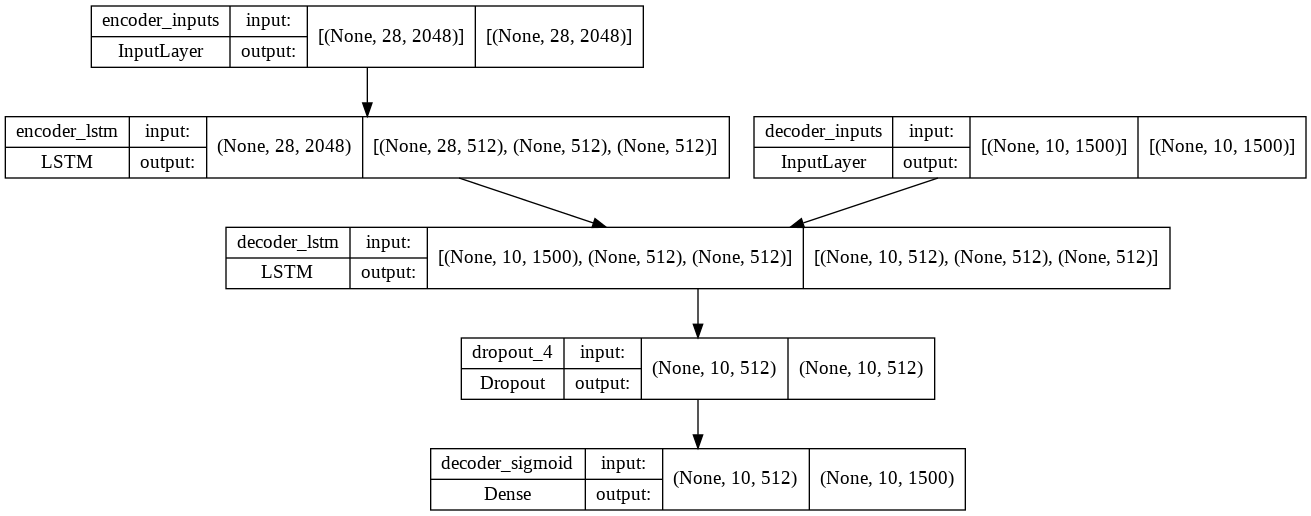

In [23]:
from keras.utils.vis_utils import plot_model
encoder_inputs = tf.keras.layers.Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens), name="decoder_inputs")
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_outputs = tf.keras.layers.Dropout(0.3)(decoder_outputs)
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='sigmoid', name='decoder_sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

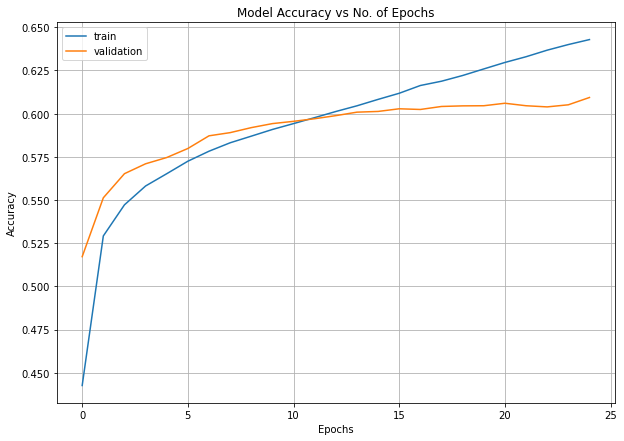

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.grid(True)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs No. of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

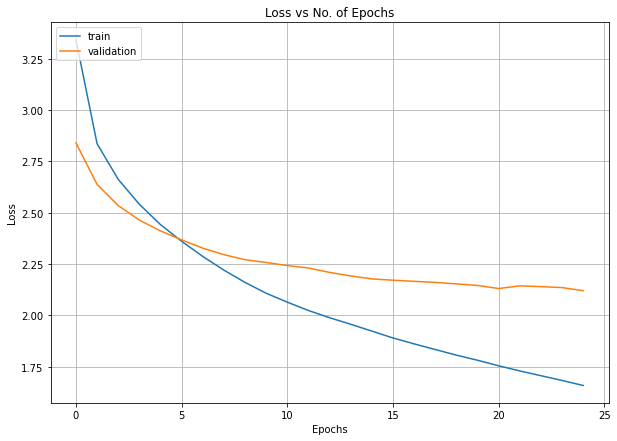

In [20]:
plt.figure(figsize=(10,7))
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs No. of Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()